In [195]:
%load_ext autoreload
%autoreload 2

import sys, os
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
#from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns, load_mapping, build_degree_buckets, compute_pvalue
from dpp.data.associations import load_diseases

# os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
diseases = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=["none"])
entrez_to_name = load_mapping("data/protein/symbol_to_entrez.txt", "\t", reverse=True,
                              b_transform=int)

In [3]:
network = PPINetwork("data/networks/bio-pathways-network.txt")

In [4]:
experiment_dir = "experiments/dpp_predict/lci_new"

# LCI

#### Load Weights
Specify a split from which to load weights

In [47]:
model_split = 1
model = torch.load(os.path.join(experiment_dir, "models", f"model_{model_split}.tar"))
ci_weights = weights['E'][0,0].numpy()

#### Weight Distribution

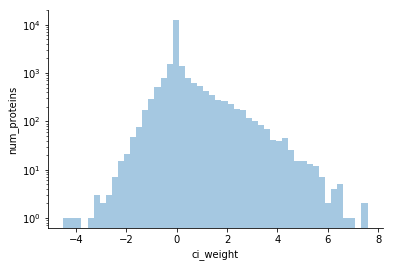

In [48]:
sns.distplot(ci_weights, kde=False)
plt.yscale('log')
plt.xlabel("ci_weight")
plt.ylabel("num_proteins")
sns.despine()

#### Degree Distribution


In [33]:
degrees = np.array(list(dict(network.nx.degree()).values()))

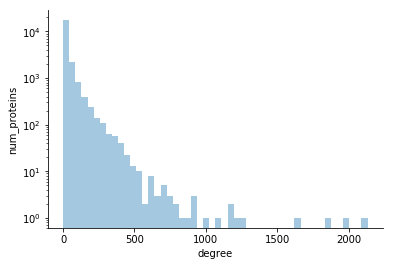

In [49]:
sns.distplot(degrees, kde=False)
plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("num_proteins")
sns.despine()

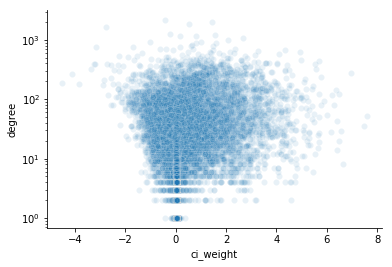

In [50]:
sns.scatterplot(ci_weights, degrees, alpha=0.1)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight")
sns.despine()

#### Gene Ontology Terms

In [53]:
obodag = GODag("data/go/go-basic.obo")

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [55]:
geneid2go = read_ncbi_gene2go("data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: data/go/gene2go.txt


In [107]:
def get_annotations(genes, level=1):
    genes_to_annotations = {gene: set() for gene in genes}
    for gene in genes:
        doids = geneid2go[gene]
        for doid in doids:
            for parent in obodag[doid].get_all_parents():
                if obodag[parent].level == level:
                    genes_to_annotations[gene].add(obodag[parent].name)

    return genes_to_annotations

In [168]:
term_to_proteins = defaultdict(set)
for protein in network.get_proteins():
    terms = get_annotations([protein], level=2)[protein]
    for term in terms:
        term_to_proteins[term].add(protein)

#### Compute p-values

In [181]:
degree_to_bucket = build_degree_buckets(network, min_len=100)

In [217]:
def get_null_pathways(pathway, quantity=1):
        """
        Given a reference pathway, generate quantity 
        """
        null_pathways = np.zeros((quantity, len(pathway)), dtype=int)
        for i, node in enumerate(pathway):
            degree = network.nx.degree[node]
            null_nodes = np.random.choice(degree_to_bucket[degree], 
                                          size=quantity, 
                                          replace=True)
            null_pathways[:, i] = null_nodes
    
        return null_pathways

In [219]:
term_to_stats = {}
for term, proteins in term_to_proteins.items():
    nodes = network.get_nodes(term_to_proteins[term])
    term_median = np.median(ci_weights[nodes])
    null_proteins = get_null_pathways(nodes, quantity=1000)
    null_medians = np.median(ci_weights[null_proteins], axis=1)
    pvalue = compute_pvalue(term_median, null_medians)
    
    term_to_stats[term] = {
        "pvalue": pvalue,
        "median_weight": term_median 
    }

In [223]:
term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
term_df.to_csv("experiments/lci_analysis/terms.csv")

protein activation cascade: 1.1441010236740112: 27
extracellular matrix binding: 0.8950749635696411: 30
structural constituent of synapse: 0.6977401375770569: 15


No handles with labels found to put in legend.


muscle adaptation: 0.5200808644294739: 31
response to stimulus involved in regulation of muscle adaptation: 0.9027151465415955: 15
morphogenesis of a branching structure: 0.6634781360626221: 141
epithelial cell proliferation: 0.7540701627731323: 68
tissue remodeling: 1.1348156929016113: 59
cyclase activity: 1.0673487186431885: 22
ovulation cycle process: 1.2375099658966064: 39
muscle cell proliferation: 1.1250356435775757: 17
circadian rhythm: 0.5538012385368347: 71
rhythmic behavior: 0.9543439149856567: 19
lymphocyte costimulation: 1.012450933456421: 51
killing of cells of other organism: 0.9743395447731018: 12
multi-organism cellular process: 1.1651887893676758: 19
ossification: 0.8992449641227722: 43
tolerance induction: 1.3184159994125366: 11
exploration behavior: 0.76203453540802: 12
organ growth: 1.2961784601211548: 20
aging: 0.5436633825302124: 82
tricarboxylic acid cycle enzyme complex: 1.096154808998108: 12
cytochrome complex: 0.9604055881500244: 25
mesenchymal cell proliferat

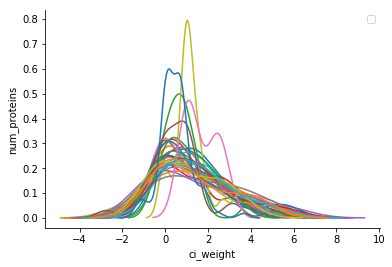

In [175]:
terms = term_to_proteins.keys() #['transcription regulator activity']
for term in terms:
    nodes = network.get_nodes(term_to_proteins[term])
    #sns.scatterplot(ci_weights[nodes], degrees[nodes], alpha=0.1, label=term)
    median = np.median(ci_weights[nodes])
    if median > 0.5 and len(nodes) > 10:
        print(f"{term}: {median}: {len(nodes)}")
        sns.distplot(ci_weights[nodes], hist=False)

plt.yscale('linear')
plt.ylabel("num_proteins")
plt.xlabel("ci_weight")
plt.legend()
sns.despine()

# Common Interactors

In [23]:
def compute_common_interactors(diseases, network, null=False): 
    """
    """
    adj = network.adj_matrix
    ci_pairs = [set() for i in range(len(network))]
    ci_diseases = [set() for i in range(len(network))]
    for disease in tqdm(diseases.values()):
        proteins = disease.to_node_array(network)
        if null:
            proteins = np.random.choice(adj.shape[0], len(proteins), replace=False)

        for a, protein_a in enumerate(proteins):
            for b, protein_b in enumerate(proteins):
                if a < b:
                    break 
                neighbors_a = adj[protein_a, :]
                neighbors_b = adj[protein_b, :]
                cis = np.where(np.multiply(neighbors_a, neighbors_b) == 1)[0]
                for ci in cis:
                    ci_pairs[ci].add((protein_a, protein_b))
                    ci_diseases[ci].add(disease.id)
    return ci_pairs, ci_diseases

In [24]:
null_pairs = []
null_diseases = []
for i in range(30): 
    ci_pairs, ci_diseases  = compute_common_interactors(diseases, network, null=True)
    null_pairs.append(ci_pairs)
    null_diseases.append(ci_diseases)

100%|██████████| 2297/2297 [04:01<00:00,  9.53it/s]  


In [25]:
null_n_pairs = [np.array(map(len, pairs)) for pairs in null_pairs]

In [ ]:
with open("experiments/dpp_evaluate/lci/null_pairs.pkl",'wb') as f:
    pickle.dump(null_pairs, f)

In [ ]:
np.stack(null_n_pairs, axis=1).shape

In [ ]:
mean_null_n_pairs = np.mean(np.stack(null_n_pairs, axis=1), axis=1)

In [ ]:
degree_vec = np.array([network.nx.degree(node) for node in range(len(network))])